# DETR

The intention of this notebook is to provide the pipeline to quickly implement DETR (Detection Transformer) on your own problem datasets.

## How it works

The main idea of DETR is to use a Transformer. Transformers are used in NLP. They are effective at the idea of attention and how words in a sentence effect other words in the sentence. The idea being that in images pixels in other areas of the image have an impact of what the objects are in other locations of the image.  

It's a simple archtitecture with performance similar to FasterRCNN. You don't have lots and lots of predictions that you then need to use non max suppression.

But it sounds like it takes a really long time to train. 

Also slightly differently it'll predict a certain number of boxes (always) and it may predict some of the boxes don't have anything in. That's okay. 

Basic Structure 

1. CNN

2. Transformer (encoder - decoder)

3. Set of box predictions 

4. Bipartite Matching 


Bipartite Matching

Always fixed N predictions 

For labeled data pad your prediction with nothing predictions so it's N long. 

You're then comparing these two things. 

You're working out a loss for each match up of the predictions and the  labels. So you can only assign one prediction to the each of the actual objects! Stops you trying to predict something quite prominent lots of times. 

You want a 1 to 1 assignment from predictions to truth that minimises the loss. Maximum benfit of the doubt. 

Then you train using the loss based on this assigment. 

Encourages the model to find diverse bounding boxes. I guess part of the key structure that removes the need for Non max  suppression. 

Hungarian loss used  - different part of the loss for category and bounding box. 

Encoder 

Takes input sequnce of the output of the CNN. 
Ouputs encoded sequence

Using attention it can aggregate information from anywhere in the image. A bounding box can be quite large so you need to be able to communicate between these locations. 

Decoder 

Take input of N object queries.
Outputs N object detection boxes with the encoder output as the side input into the decoder.

Not quite understood yet - these object queries are learnt. Each object query asks a different question of the image. So one might ask, what small object are in the bottom left. 

Classifier 
The object queries then go through a classifier

Understanding Transformers is really important
Attention is all you need:
(could still do with spending some time getting more familiar with attention - as it helps understanding) 
https://www.youtube.com/watch?v=iDulhoQ2pro


### Video talking throught the paper
https://www.youtube.com/watch?v=T35ba_VXkMY

They give you code at the bottom of the paper and there's also pretrained versions available from facebook. 


Clone the facebook git repository. 
I ran this in the command line. 
git clone https://github.com/facebookresearch/detr.git 

Cloned the detr git to get access to the bipartite matching loss functions. 

# Section 1: Using a pretrained model 
Super useful colab notebook - in many ways you don't want to do this locally as you'll want gpus.

https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb#scrollTo=07IsWxj2YTEY

In [1]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [2]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [3]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [4]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [5]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


In [7]:
url = 'https://github.com/AndrewWalker251/object_detection_methods/blob/master/DETR/andy_murray.jpg?raw=true'
im = Image.open(requests.get(url, stream=True).raw)

In [8]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

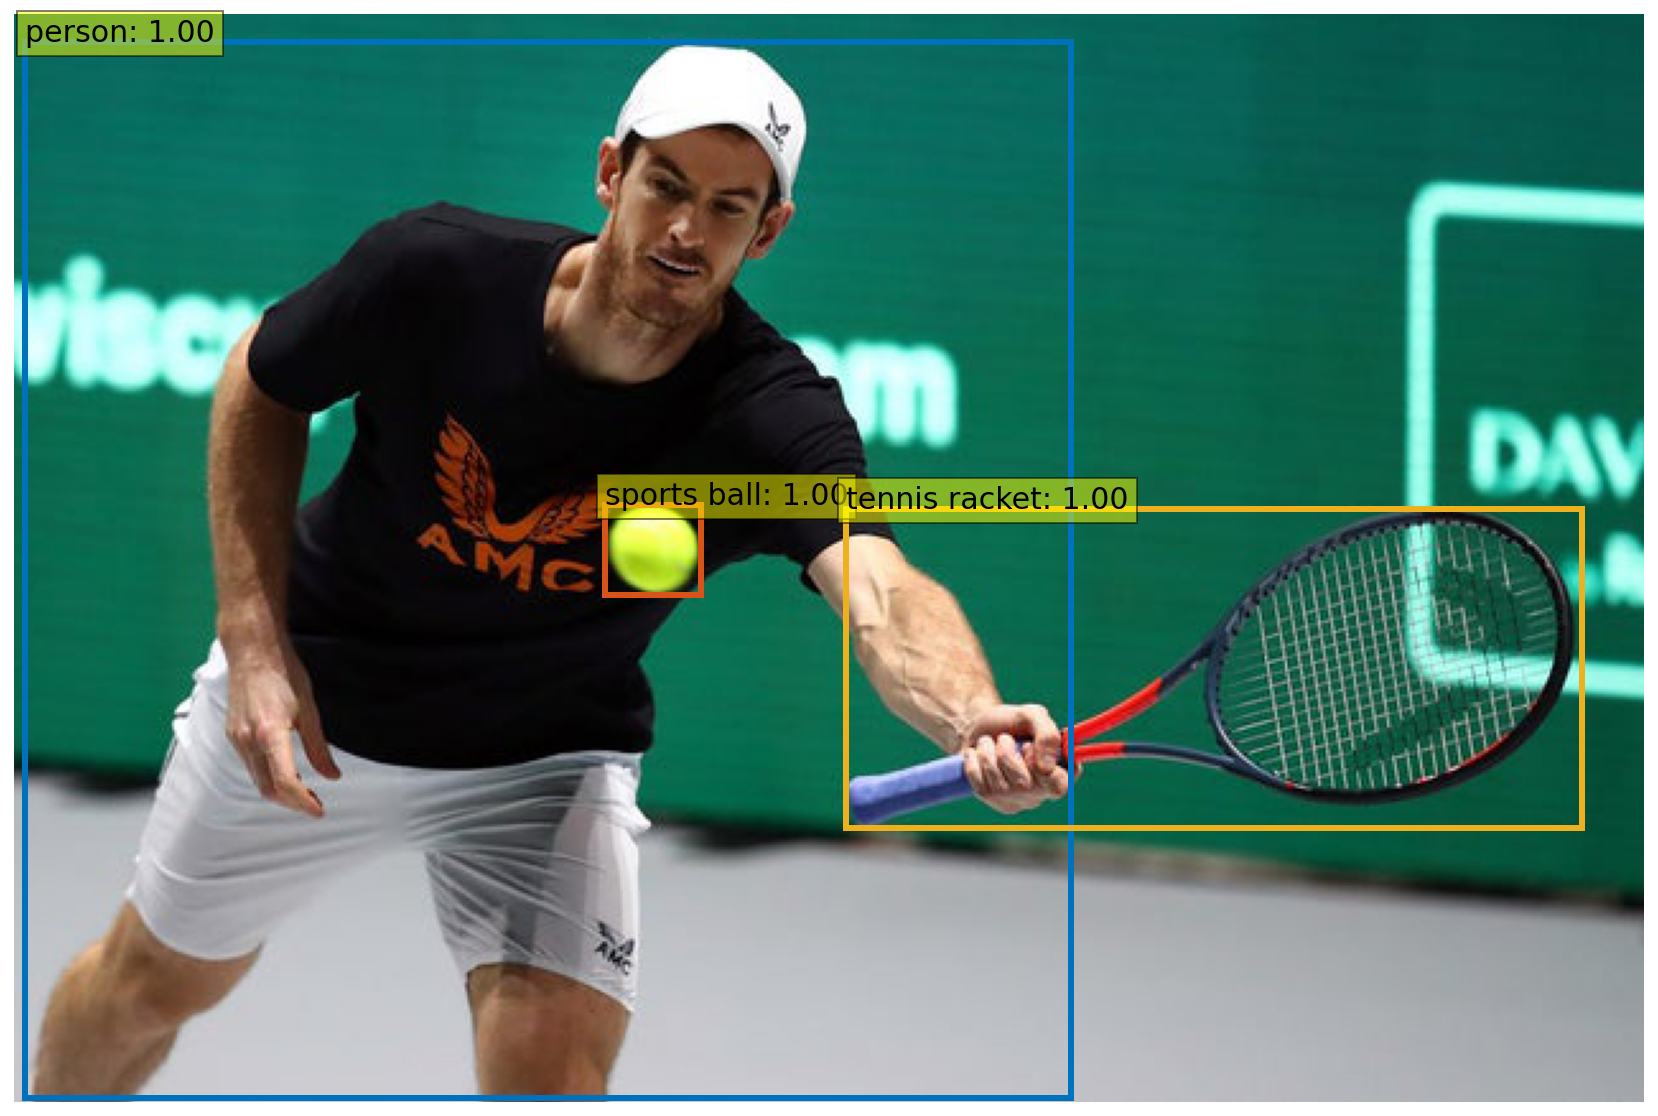

In [10]:
plot_results(im, probas[keep], bboxes_scaled)

In [ ]:
# TEsting commiting from Colab. 

# Wo